In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SALib
from SALib.plotting import bar
import seaborn as sns
# read Sobol' sensitivity indices as dataframe
from settings import *
from utils.test_function_setting import set_sobol_g_func
from pandas.core.common import flatten
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

## Plot Sobol' SA with dummy parameter included

<Figure size 576x432 with 0 Axes>

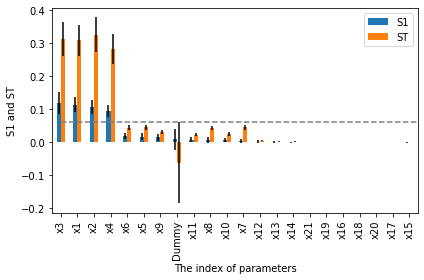

In [2]:
df = pd.read_csv(f'../output/sobol/Sobol_indices.csv', index_col = 'Unnamed: 0')
a, x, x_bounds, x_names, len_params, problem = set_sobol_g_func()

df_plot = pd.DataFrame()
df_plot.loc[:, 'S1'] = df[df.Type == 'S1']['result_5000'].values
df_plot.loc[:, 'S1_conf'] = df[df.Type == 'S1_conf']['result_5000'].values
df_plot.loc[:, 'ST'] = df[df.Type == 'ST']['result_5000'].values
df_plot.loc[:, 'ST_conf'] = df[df.Type == 'ST_conf']['result_5000'].values
threshold = df_plot.loc[21, 'ST'] + df_plot.loc[21, 'ST_conf']

df_plot.index = [* problem['names'], 'Dummy']
df_plot.sort_values(by='S1', ascending=False, inplace=True)
fig = plt.figure(figsize = (8, 6))
ax = bar.plot(df_plot)
# ax.set_xticklabels([* problem['names'], 'Dummy'])
ax.set_xlabel('The index of parameters')
ax.set_ylabel('S1 and ST')
plt.tight_layout()
plt.hlines(threshold, xmin=0, xmax=22, colors = 'grey', linestyle='--')
plt.savefig(f'../output/sobol/Sobol_dummy.png', format = 'png', dpi = 300)

## Plot the adaptive evaluation

In [3]:
from settings import *
df = {}
filename = ['fix_9'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
fpath = '../output/replicates/morris/sobol_vertical/'

for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}/mean_estimation.csv', index_col = 'Unnamed: 0').iloc[0:10]
    df[fn].index = df[fn].index.astype('int')
    df[fn].index = (df[fn].index + 1) * 10

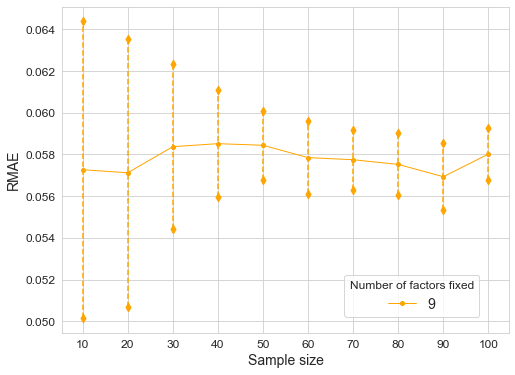

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fs = 12
sns.set_style('whitegrid')
plt.rcParams['legend.title_fontsize'] = 12
lgd = [ii.split('_')[1] for ii in filename]
METRIC_NAME = [METRIC_NAME[0]]
metrics = [fn for fn in METRIC_NAME if not '_' in fn ]
colors = ['lightgreen', 'orange', 'cornflowerblue']
for ii in range(len(metrics)):
    metric = metrics[ii]
    k = 1
    for fn in filename:  
        df_plot = df[fn]
        lower = df_plot.loc[:, f'{metric}_mean'] - df_plot.loc[:, f'{metric}_std']
        upper = df_plot.loc[:, f'{metric}_mean'] + df_plot.loc[:, f'{metric}_std']
        # logy = True if ii == 0 else False
        ax = df_plot.loc[:, metric + '_mean'].plot(kind='line', marker='o', linewidth=1, style='-', ms=4, ax = axes, alpha=1.0, logy=False, color=colors[k])
        ax.scatter(df_plot.index, lower, marker = 'd', color= colors[k])
        ax.scatter(df_plot.index, upper, marker = 'd', color=colors[k])
        ax.vlines(df_plot.index, lower, upper, linestyle = '--', color=colors[k])
        k += 1
        # ax.hlines(0.94, df_plot.index[0], df_plot.index[-1], linestyle = '--', colors='grey')   
    ax.set_xlabel('Sample size', fontsize=14);
    ax.set_ylabel('RMAE', fontsize = 14);
    # ax.set_ylim(0.8, 1.2)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)
    ax.legend(lgd, title='Number of factors fixed', fontsize = 14, ncol=2, bbox_to_anchor=(0.95, 0.2))
plt.savefig('../output/replicates/figure/fig4_mean_horizontal.tif', format = 'tif', dpi = 400)

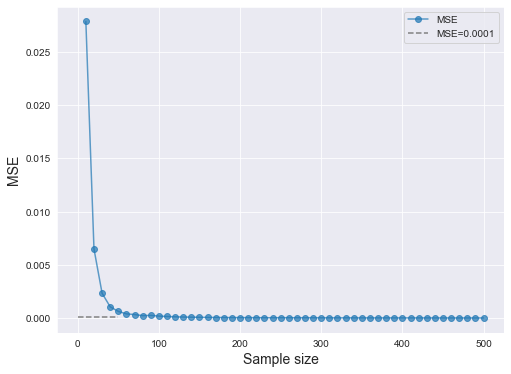

In [94]:
# Plot the MSE of the mean using variance and the sample size
sns.set_style('darkgrid')
ax = mse.iloc[:50].plot(legend=False, figsize = (8, 6), marker = 'o', alpha = 0.7)
ax.set_xlabel('Sample size', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
hlines_value = 0.0001
plt.hlines(hlines_value, xmin=0, xmax=50, colors='grey', linestyles='--')
ax.legend(['MSE', f'MSE={hlines_value}'])
# plt.savefig('../output/figure/mse_lhs.png', format = 'png', dpi = 300)

## Plot Figure 7 

In [8]:
from settings import *
df = {}
filename = ['fix_6', 'fix_9', 'fix_10', 'fix_13', 'fix_17']
fpath = '../output/replicates/morris/sobol_vertical/'
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}/mean_estimation.csv', index_col = 'Unnamed: 0').iloc[9]
df_metric = pd.DataFrame.from_dict(df, orient = 'index')
new_index = [ind.split('_')[1] for ind in list(df_metric.index)]
df_metric.index = new_index
# df_metric

In [9]:
# obtain relative bias    
cols = df_metric.columns
df_metric.fillna(value=0.0, inplace=True)
df_metric['ppmc_mean'] = df_metric['ppmc_mean'].apply(lambda x: 1 - x)
df_metric['var_mean'] = df_metric['var_mean'].apply(lambda x: np.abs(1 - x))

# drop the first row due to RMAE > 0.40
cols = df_metric.columns
yerror = [df_metric.loc[:, col].values for col in cols[-3:]]
x = df_metric.index
# df_metric.index = ([str(21 - i) for i in x])


In [10]:
# import the analytic variance 
fvariance = np.loadtxt('../data/variance_frac.txt')
# total_variance = 2.755
index_fix = np.array([[20, 17, 19, 15, 16, 18], [14, 12, 13], 
                    [11], [9, 10, 8], [7, 6, 5, 4], [2, 3, 0, 1]])
variance_frac = fvariance[[len(list(flatten(index_fix[0:i+1])))-1 for i in range(index_fix.size-1)]] / 100
variance_frac = np.append(variance_frac, fvariance[-1])
variance_frac = variance_frac[[0, 1, 2, 3, 4]]

<Figure size 432x360 with 0 Axes>

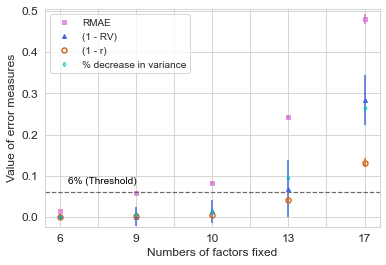

In [12]:

sns.set_style('whitegrid')
fig = plt.figure(figsize=(6, 5))
# form x label
num_in_groups = []
conf_names = [col for col in METRIC_NAME if '_conf' in col]
colors = ['orchid', 'royalblue','chocolate']
ax = df_metric[cols[:3]].plot(kind='line', yerr=yerror, linestyle='', color=colors)

x = df_metric.index
x_ticklabels = ['{}{}{}{}'.format(i+1, ' (', x[i], ')') for i in range(len(x))]

ax.plot(x, df_metric[METRIC_NAME[0]+'_mean'], 's', color=colors[0], ms=4, alpha=0.7, label='RMAE')
ax.plot(x, df_metric[METRIC_NAME[1]+'_mean'], '^', color=colors[1], ms=4, label='RV')
ax.plot(x, df_metric[METRIC_NAME[2]+'_mean'], 'o', ms=5, markerfacecolor='none',label='PPMC',
        markeredgecolor=colors[2], markeredgewidth=1.5)
          
ax.plot(x, variance_frac, 'd', ms=3, markerfacecolor='none',label='First-order variance',
        markeredgecolor='c', markeredgewidth=1.5, alpha=0.7)            
                                                                  
ax.axhline(y=0.06, xmin=0, xmax=6, linestyle='--', linewidth=1.2, color='dimgrey')
ax.tick_params(axis='both', labelsize=12)

ax.set_xlabel('Numbers of factors fixed', fontsize=12)
ax.set_ylabel('Value of error measures', fontsize=12)
# ax.set_ylim(-0.03, 0.5)
# ax.set_xlim(0.85, 7.15)

ax.legend(['RMAE', '(1 - RV)', '(1 - r)', '% decrease in variance'], loc='upper left', fontsize=10)
ax.text(0.1, 0.08, '6% (Threshold)', fontsize=10, color='k')
plt.savefig('{}{}{}'.format('../output/replicates/figure/', 'fig7_variance', '.png'), dpi=300, format='png')

## Figure 7

In [14]:
"""Create figure 7 for paper."""
from settings import *

# plot for figure type I
f_dir = ['../output/reuse_sample/morris/compare/'+'0.25/',
         '../output/reuse_sample/sobol/compare/'+'0.25/']
f_names = ['mae', 'mae_lower','mae_upper']
def f_read(filename):
    df = pd.read_csv(filename)
    df.drop(columns = 'Unnamed: 0', inplace=True)
    df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
    return df

<Figure size 720x432 with 0 Axes>

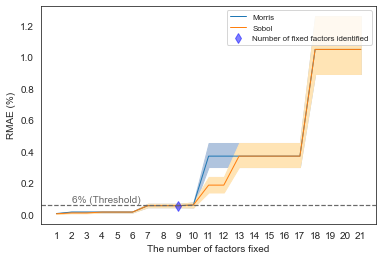

In [15]:


sample_size = ['result_80', 'result_800']
f_morris = f_read(f'{f_dir[0]}{f_names[0]}.csv')
mae_comp = pd.DataFrame(index=f_morris.index)
mae_comp['Morris'] = f_morris[sample_size[0]]
mae_comp['Sobol'] = f_read(f'{f_dir[1]}{f_names[0]}.csv').loc[:, sample_size[1]]
mae_comp['Morris_lower'] = f_read(f'{f_dir[0]}{f_names[1]}.csv').loc[:, sample_size[0]]
mae_comp['Morris_upper'] = f_read(f'{f_dir[0]}{f_names[2]}.csv').loc[:, sample_size[0]]
mae_comp['Sobol_lower'] = f_read(f'{f_dir[1]}{f_names[1]}.csv').loc[:, sample_size[1]]
mae_comp['Sobol_upper'] = f_read(f'{f_dir[1]}{f_names[2]}.csv').loc[:, sample_size[1]]

cols =  mae_comp.columns

fig = plt.figure(figsize=(10, 6))
sns.set_style('white')
palette = plt.get_cmap('Set1')
col_conf = [col for col in cols if '_conf' in col]
ax = mae_comp[cols[0:2]].plot(kind='line', linewidth=1)
ax.fill_between(mae_comp.index, mae_comp['Morris_lower'], 
                mae_comp['Morris_upper'],color='lightsteelblue', label=f'95% CIs for Morris')                
ax.fill_between(mae_comp.index, mae_comp['Sobol_lower'], 
                mae_comp['Sobol_upper'],color='moccasin', label=f'95% CIs for Sobol')

ax.plot(mae_comp['Sobol'][8:9], 'd', color='blue', alpha=0.5, ms=7,
        label='Number of fixed factors identified')
ax.axhline(y=0.06, xmin=0, xmax=21, linestyle='--', linewidth=1.2, color='dimgrey')

ax.set_xticks(range(len(mae_comp)))
ax.set_xticklabels(np.arange(1, 22));
ax.set_xlabel('The number of factors fixed', fontsize=10)
ax.set_ylabel('RMAE (%)', fontsize=10)
leg = ax.legend(['Morris', 'Sobol',
                 'Number of fixed factors identified',
                 ], #'Threshold (6%)','95% CIs for Morris', '95% CIs for Sobol'
                fontsize = 8)
ax.text(1, 0.08, '6% (Threshold)', fontsize=10, color='dimgrey')            
plt.savefig(f'../output/reuse_sample/figure/fig7_sa_compare.png', dpi=300, format='png')

## Plot Figure 8

In [2]:
path = '../output/replicates/morris/sobol_vertical/'
f_default = np.append([0, 0.1, 0.4, 0.5], np.linspace(0.2, 0.3, 11))
f_default.sort()
f_default = [round(i, 2) for i in f_default]
# f_default[0] = '0.00'

In [3]:
df = {}
f_read_6 = pd.read_csv('{}{}{}'.format(path, 'fix_6', '.csv'), index_col = 'Unnamed: 0')
f_read_9 = pd.read_csv('{}{}{}'.format(path, 'fix_9', '.csv'),  index_col = 'Unnamed: 0')
for fn in METRIC_NAME:
    df[fn] = pd.DataFrame(columns=['group1', 'group2'], index=f_default)
    for val in f_default:
        df[fn].loc[val, 'group1'] = f_read_6.loc[val, fn]
        df[fn].loc[val, 'group2'] = f_read_9.loc[val, fn]

In [9]:
df

{'mae':          group1     group2
 0.00  0.0742679   0.310841
 0.10   0.043643   0.178314
 0.20  0.0184308   0.077181
 0.21  0.0166814  0.0689935
 0.22  0.0153341   0.064249
 0.23  0.0148255  0.0627097
 0.24  0.0136873  0.0586594
 0.25  0.0135878  0.0585247
 0.26  0.0136072  0.0551047
 0.27  0.0147629  0.0563072
 0.28  0.0154111  0.0594554
 0.29  0.0166627  0.0639243
 0.30   0.017612  0.0693756
 0.40  0.0421547   0.147803
 0.50  0.0696754   0.237619,
 'var':         group1    group2
 0.00   1.16215   1.73108
 0.10   1.09073   1.38626
 0.20   1.02593   1.12928
 0.21    1.0224   1.09328
 0.22    1.0135   1.08378
 0.23   1.01362   1.02221
 0.24     1.008   1.02253
 0.25   1.00033  0.994283
 0.26  0.998197   1.00768
 0.27  0.987542  0.948693
 0.28  0.982523  0.937233
 0.29  0.984009  0.918671
 0.30  0.977586  0.919082
 0.40  0.919711  0.723328
 0.50  0.864583  0.574969,
 'ppmc':         group1    group2
 0.00  0.999886  0.997422
 0.10  0.999856  0.997241
 0.20  0.999852  0.997779
 0.21  0

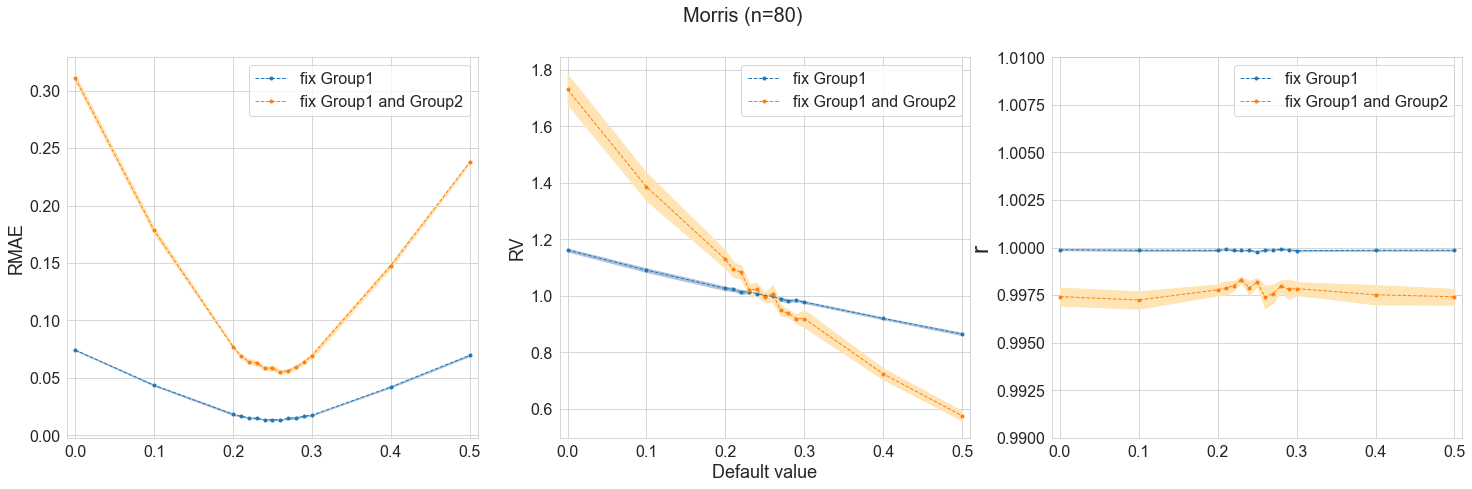

In [4]:

# transform df from dict into dataframe with multiple columns
df = pd.concat(df, axis=1)
df.index = [float(i) for i in df.index]
df=df.astype('float')

def plot_shadow(col_name, ax, ylabel, ylim=None, fs=None):
    df[col_name].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax=ax)
    ax.fill_between(df.index, df[f'{col_name}_lower', 'group1'], df[f'{col_name}_upper', 'group1'], color='lightsteelblue')
    ax.fill_between(df.index, df[f'{col_name}_lower', 'group2'], df[f'{col_name}_upper', 'group2'], color='moccasin')
    ax.set_xlim(-0.01, 0.51)
    if not (ylim==None):
        ax.set_ylim(ylim[0], ylim[1])
    ax.tick_params(axis='both', which='major', labelsize=16)
    if fs == None:
        ax.set_ylabel(ylabel, fontsize=18)
    else:
        ax.set_ylabel(ylabel, fontsize=24)    
    ax.legend(['fix Group1', 'fix Group1 and Group2'], fontsize=16)
# End plot_shadow()

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
plot_shadow('mae', axes[0], 'RMAE')
plot_shadow('var', axes[1], 'RV')
fig.suptitle('Morris (n=80)', fontsize=20)
axes[1].set_xlabel('Default value',  fontsize=18)
plot_shadow('ppmc', axes[2], 'r', [0.990, 1.010], 26)

plt.savefig(f'../output/replicates/figure/fig8_evaluate_defaults.png', format='png', dpi=300)
